In [54]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Volatility Smirk:

Option Data from OptionMetrics, Stock Price Data from CRSP.

Date: 2021/01/01~2021/12/31

### Option Filters:

    time to maturity: 10~60
    OI > 0
    IV: 0.03 ~ 2.00
    Volume: Non Missing
    Option Price = mean(bid, ask) > $0.025
    
### Stock Price Filters:

    Volume > 0
    Stock Price > $5

In [2]:
option = pd.read_csv('option data for smirk.csv')

option['price'] = 0.5*(option['best_bid'] + option['best_offer'])
option = option[option['price']>=0.125]
option['strike'] = option['strike_price']/1000
option = option[['date', 'exdate', 'ticker', 'cp_flag', 'strike', 'impl_volatility']]

option

,date,exdate,ticker,cp_flag,strike,impl_volatility
0,2021-01-04,2021-01-15,XLB,C,50.0,1.003995
1,2021-01-04,2021-01-15,XLB,C,54.0,0.693605
2,2021-01-04,2021-01-15,XLB,C,58.0,0.535532
3,2021-01-04,2021-01-15,XLB,C,59.0,0.497176
4,2021-01-04,2021-01-15,XLB,C,60.0,0.459211
...,...,...,...,...,...,...
603954,2021-12-31,2022-02-18,XLC,P,77.0,0.169753
603955,2021-12-31,2022-02-18,XLC,P,78.0,0.161513
603956,2021-12-31,2022-02-18,XLC,P,79.0,0.154420
603957,2021-12-31,2022-02-18,XLC,P,81.0,0.144884


In [3]:
stock = pd.read_csv('stock data for smirk.csv')
stock.rename(columns = {'DlyCalDt' : 'date', 'Ticker' : 'ticker', 'DlyPrc' : 'price'}, inplace = True)
stock = stock[['date', 'ticker', 'price']]
stock

,date,ticker,price
0,2021-01-04,XLRE,35.38
1,2021-01-04,XLC,66.48
2,2021-01-04,XLB,71.70
3,2021-01-04,XLP,66.72
4,2021-01-04,XLY,159.42
...,...,...,...
2515,2021-12-31,XLE,55.50
2516,2021-12-31,XLF,39.05
2517,2021-12-31,XLI,105.81
2518,2021-12-31,XLK,173.87


## Merge Data and Calculate Moneyness

In [4]:
df = pd.merge(option, stock, on = ['date', 'ticker'])
df.dropna(inplace = True)
df['moneyness'] = df['strike']/df['price']
df

,date,exdate,ticker,cp_flag,strike,impl_volatility,price,moneyness
0,2021-01-04,2021-01-15,XLB,C,50.0,1.003995,71.70,0.697350
1,2021-01-04,2021-01-15,XLB,C,54.0,0.693605,71.70,0.753138
2,2021-01-04,2021-01-15,XLB,C,58.0,0.535532,71.70,0.808926
3,2021-01-04,2021-01-15,XLB,C,59.0,0.497176,71.70,0.822873
4,2021-01-04,2021-01-15,XLB,C,60.0,0.459211,71.70,0.836820
...,...,...,...,...,...,...,...,...
497534,2021-12-31,2022-02-18,XLC,P,77.0,0.169753,77.68,0.991246
497535,2021-12-31,2022-02-18,XLC,P,78.0,0.161513,77.68,1.004119
497536,2021-12-31,2022-02-18,XLC,P,79.0,0.154420,77.68,1.016993
497537,2021-12-31,2022-02-18,XLC,P,81.0,0.144884,77.68,1.042739


# ATM Call IV:

### 計算 moneyness 最接近1的履約價，並以該履約價中的各到期日買權隱含波動度取平均

In [5]:
CallIVmean = df[df['cp_flag'] == 'C'].groupby(['date', 'ticker', 'moneyness']).agg({'impl_volatility': 'mean'}).reset_index(level = ['ticker', 'moneyness'])
CallIVmean = CallIVmean.reset_index()
CallIVmean = CallIVmean.groupby(['date', 'ticker']).apply(lambda x: x.iloc[(abs(x['moneyness'] - 1)).argsort()[:1]]).reset_index(level =['date', 'ticker'], drop = True).reset_index(drop = True)
CallIVmean = CallIVmean[['date', 'ticker', 'impl_volatility']]
CallIVmean.rename(columns = {'impl_volatility':'ATMC_IV'}, inplace = True)
CallIVmean

,date,ticker,ATMC_IV
0,2021-01-04,XLB,0.269287
1,2021-01-04,XLC,0.266463
2,2021-01-04,XLE,0.407613
3,2021-01-04,XLF,0.278703
4,2021-01-04,XLI,0.277330
...,...,...,...
2515,2021-12-31,XLK,0.193551
2516,2021-12-31,XLP,0.116787
2517,2021-12-31,XLRE,0.152987
2518,2021-12-31,XLU,0.134590


# OTM Put IV:

### 首先取得 moneyness 小於0.95的 Put，再取 moneyness 最大的履約價，
### 在該履約價中的所有天期賣權計算IV平均

In [6]:
PutIVmean = df[df['cp_flag'] == 'P'].groupby(['date', 'ticker', 'moneyness']).agg({'impl_volatility': 'mean'}).reset_index(level = ['ticker', 'moneyness'])
PutIVmean = PutIVmean.reset_index()
PutIVmean = PutIVmean[PutIVmean['moneyness']<0.95]
PutIVmean = PutIVmean.groupby(['date', 'ticker']).apply(lambda x: x.iloc[(x['moneyness'].argsort()[-1:])]).reset_index(level =['date', 'ticker'], drop = True).reset_index(drop = True)
PutIVmean = PutIVmean[['date', 'ticker', 'impl_volatility']]
PutIVmean.rename(columns = {'impl_volatility':'OTMP_IV'}, inplace = True)
PutIVmean

,date,ticker,OTMP_IV
0,2021-01-04,XLB,0.305947
1,2021-01-04,XLC,0.313966
2,2021-01-04,XLE,0.415925
3,2021-01-04,XLF,0.309001
4,2021-01-04,XLI,0.301269
...,...,...,...
2513,2021-12-31,XLK,0.232681
2514,2021-12-31,XLP,0.182445
2515,2021-12-31,XLRE,0.199524
2516,2021-12-31,XLU,0.177366


## BOX Plot

In [7]:
IV = pd.merge(CallIVmean, PutIVmean, on = ['date', 'ticker'])
IV['skew'] = IV['OTMP_IV'] - IV['ATMC_IV']

merged = pd.merge(IV, stock, on = ['date', 'ticker'])
merged['ret'] = merged.groupby('ticker')['price'].pct_change()
merged.dropna(inplace = True)
merged['date'] = pd.to_datetime(merged['date'], format='%Y-%m-%d')
merged

,date,ticker,ATMC_IV,OTMP_IV,skew,price,ret
10,2021-01-05,XLB,0.246122,0.296004,0.049881,73.31,0.022455
11,2021-01-05,XLC,0.252246,0.328263,0.076017,66.72,0.003610
12,2021-01-05,XLE,0.409715,0.407416,-0.002299,39.66,0.044784
13,2021-01-05,XLF,0.275474,0.303104,0.027630,29.21,0.004470
14,2021-01-05,XLI,0.262123,0.293413,0.031290,87.26,0.009837
...,...,...,...,...,...,...,...
2513,2021-12-31,XLK,0.193551,0.232681,0.039130,173.87,-0.004865
2514,2021-12-31,XLP,0.116787,0.182445,0.065659,77.11,0.006789
2515,2021-12-31,XLRE,0.152987,0.199524,0.046537,51.81,0.002128
2516,2021-12-31,XLU,0.134590,0.177366,0.042776,71.58,0.003505


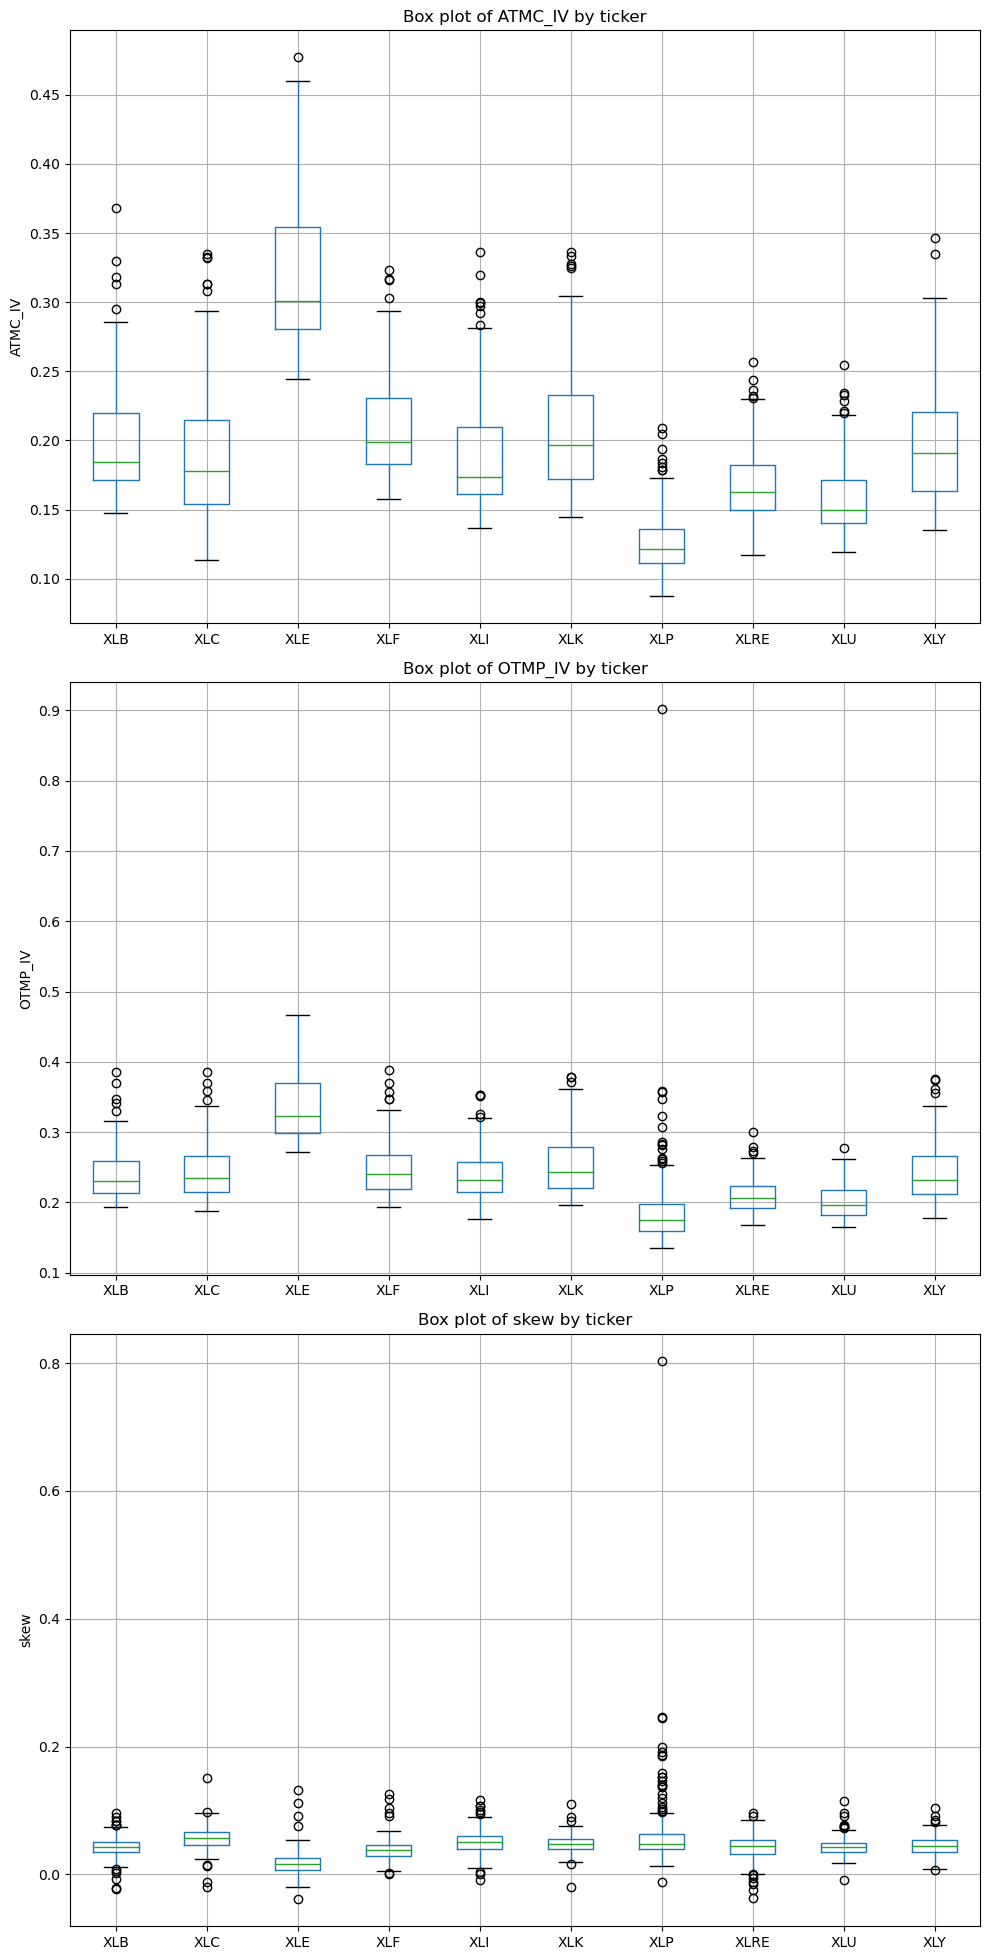

In [65]:
import matplotlib.pyplot as plt

# 创建一个带有3个子图的画布，每个子图都放在垂直方向上
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))

# 在每个子图上绘制对应的箱线图
merged.boxplot(column='ATMC_IV', by='ticker', ax=axes[0])
merged.boxplot(column='OTMP_IV', by='ticker', ax=axes[1])
merged.boxplot(column='skew', by='ticker', ax=axes[2])

# 设置每个子图的标题和副标题
axes[0].set_title('Box plot of ATMC_IV by ticker')
axes[0].set_xlabel('')
axes[0].set_ylabel('ATMC_IV')
axes[1].set_title('Box plot of OTMP_IV by ticker')
axes[1].set_xlabel('')
axes[1].set_ylabel('OTMP_IV')
axes[2].set_title('Box plot of skew by ticker')
axes[2].set_xlabel('')
axes[2].set_ylabel('skew')

# 调整子图之间的距离和边距
plt.tight_layout()

# 显示图形
plt.suptitle('')
plt.show()

# 查看 Skew 與股價報酬的相關性：
### Skew = 價外賣權IV - ATM買權IV : Skew 越高代表市場看跌，報酬應越低，故 Skew 與 ret 的相關性應為負

In [66]:
grouped = merged.groupby('ticker')
for s in range(15):
    corr_df = pd.DataFrame(columns=['ticker', 'corr_skew_ret'])
    for ticker, group in grouped:
        corr_skew_ret = group['skew'].corr(group['ret'].shift(s))
        corr_df = corr_df.append({'ticker': ticker, 'corr_skew_ret': corr_skew_ret}, ignore_index=True)

    # 顯示結果
    print(f'相差日數:{s} \n', corr_df, '\n')

相差日數:0 
   ticker  corr_skew_ret
0    XLB       0.129099
1    XLC       0.211860
2    XLE      -0.065988
3    XLF       0.117965
4    XLI       0.064703
5    XLK       0.061016
6    XLP      -0.024259
7   XLRE       0.165060
8    XLU       0.066237
9    XLY       0.027867 

相差日數:1 
   ticker  corr_skew_ret
0    XLB      -0.027436
1    XLC       0.069420
2    XLE      -0.188382
3    XLF      -0.191506
4    XLI       0.044794
5    XLK       0.021507
6    XLP       0.001224
7   XLRE      -0.035962
8    XLU       0.088664
9    XLY      -0.066520 

相差日數:2 
   ticker  corr_skew_ret
0    XLB      -0.005653
1    XLC      -0.003240
2    XLE      -0.069294
3    XLF      -0.062044
4    XLI      -0.009110
5    XLK      -0.105005
6    XLP      -0.038860
7   XLRE       0.004770
8    XLU       0.026248
9    XLY      -0.088507 

相差日數:3 
   ticker  corr_skew_ret
0    XLB       0.096753
1    XLC       0.012405
2    XLE      -0.053715
3    XLF       0.024413
4    XLI       0.042367
5    XLK       0.07086

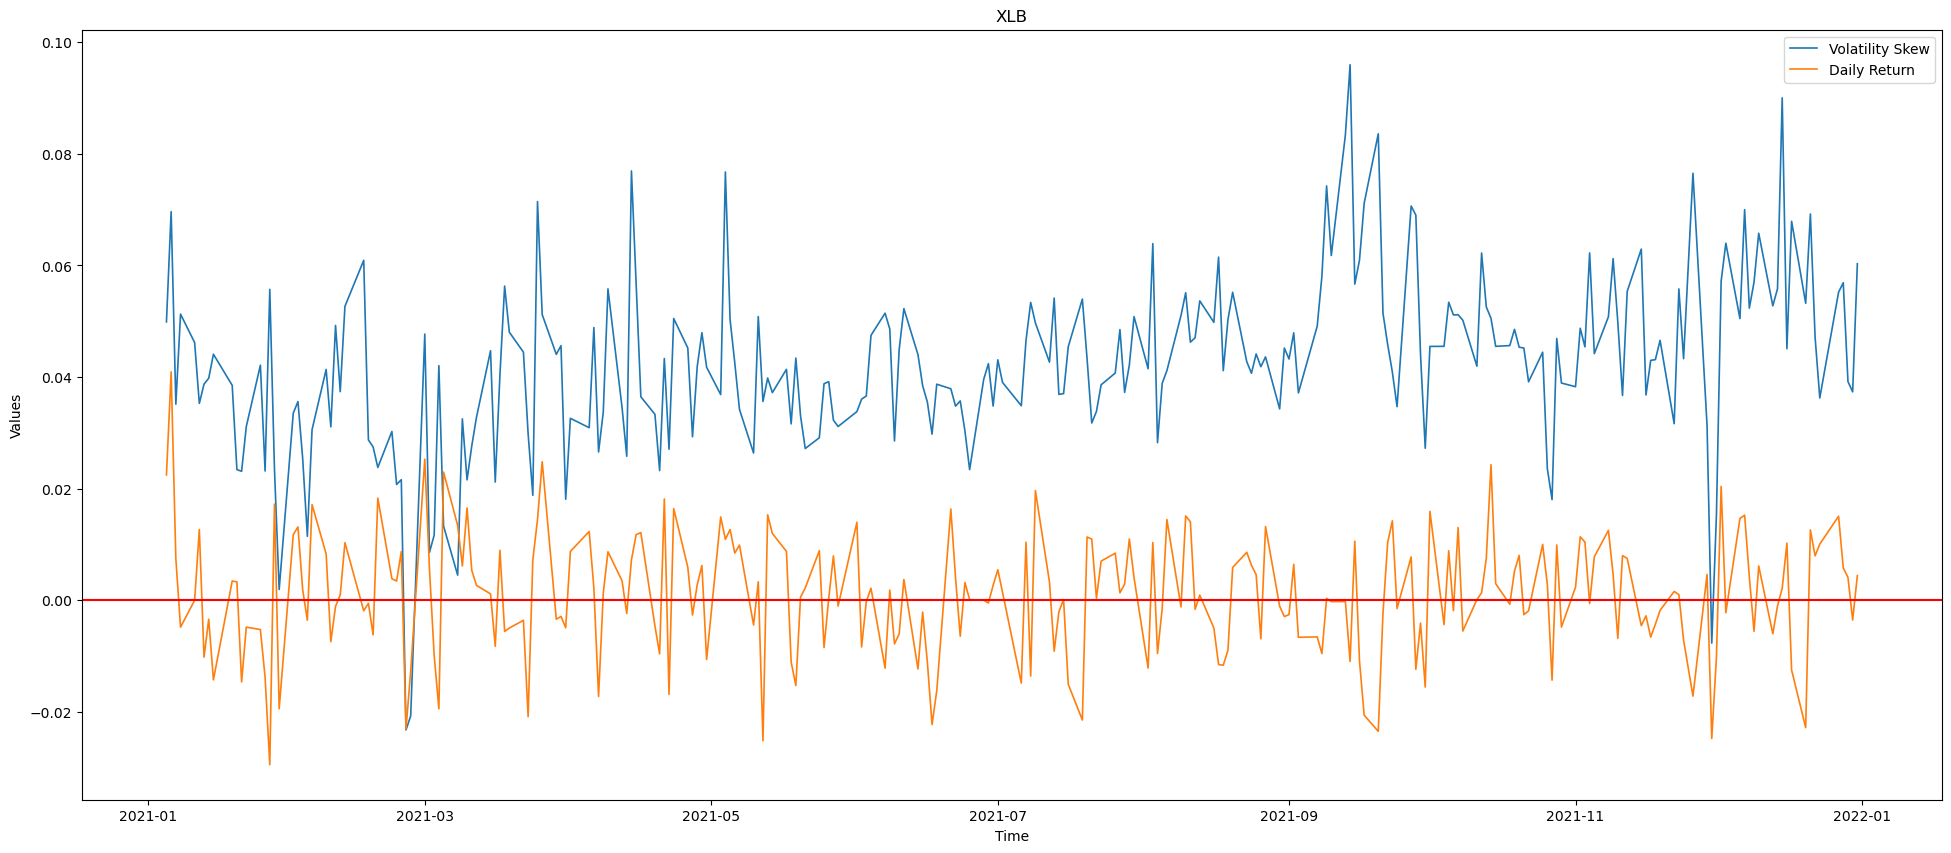

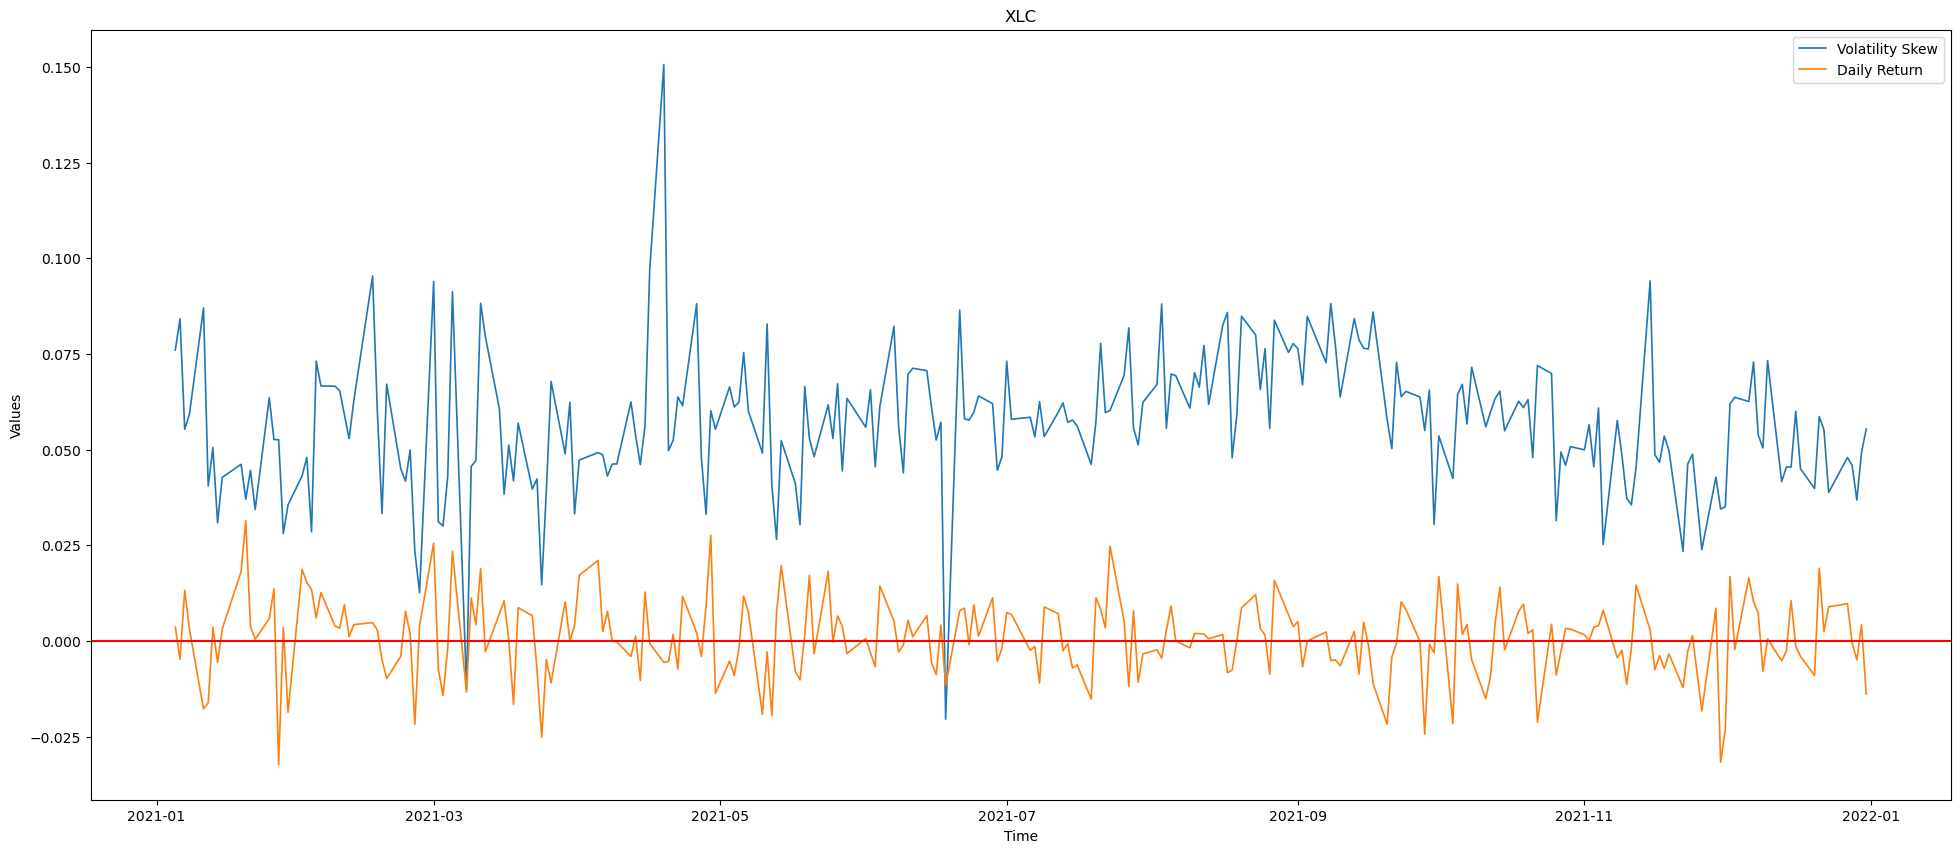

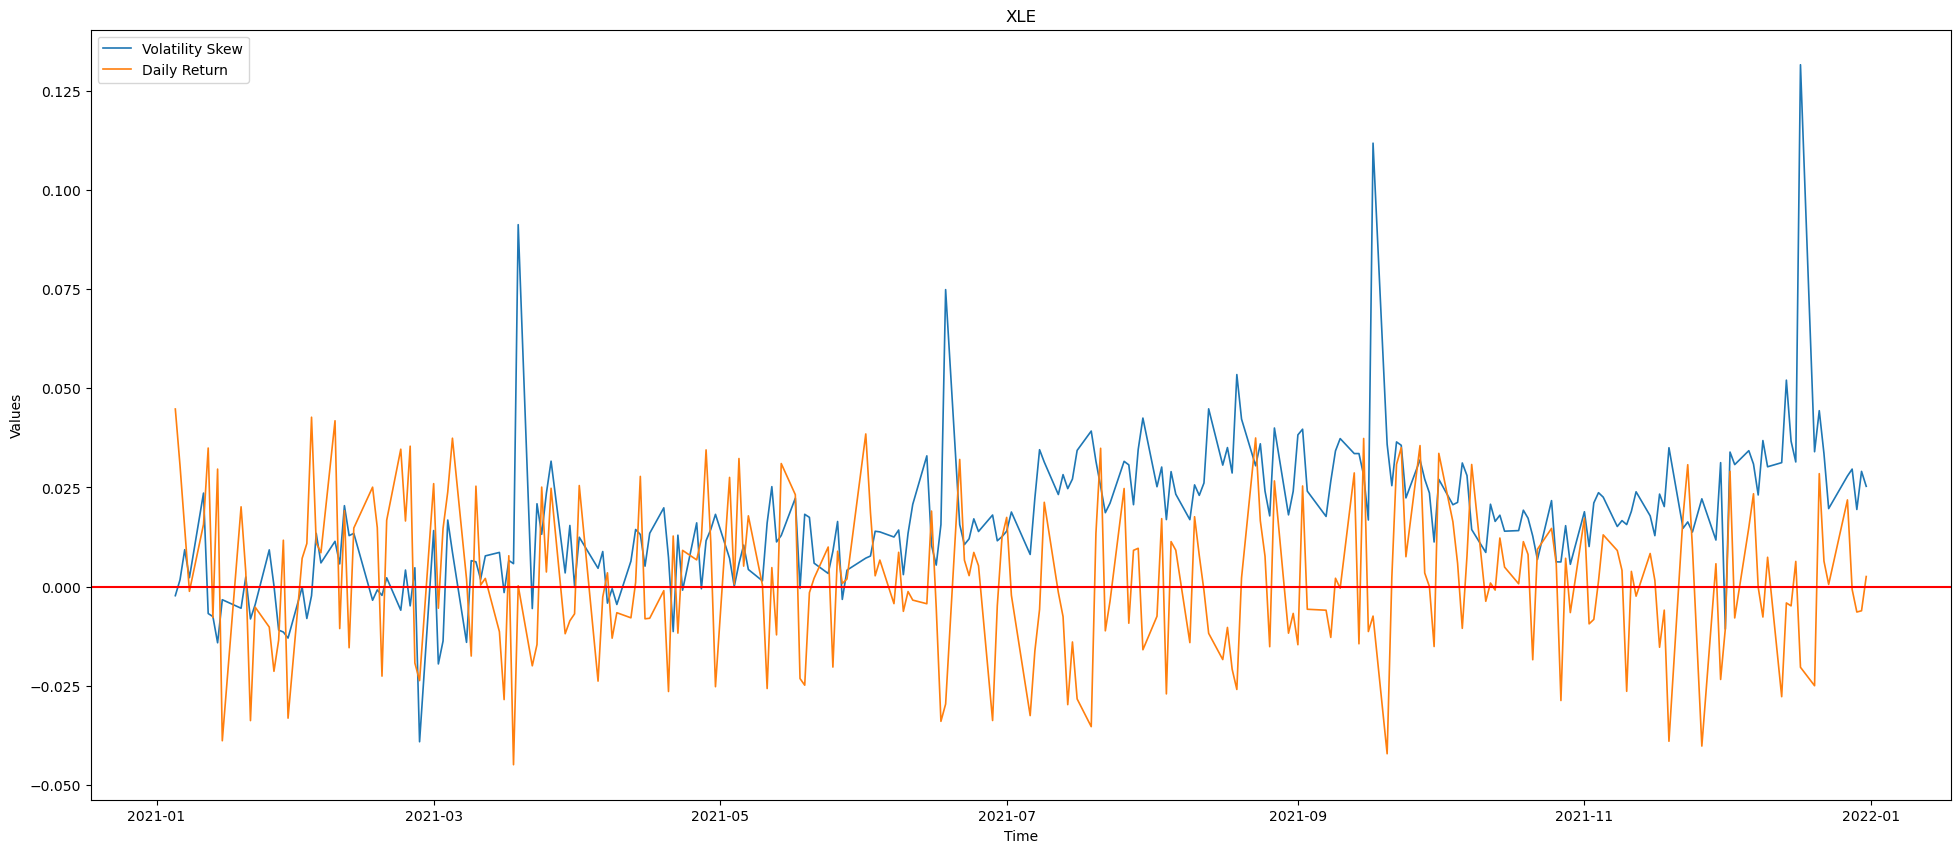

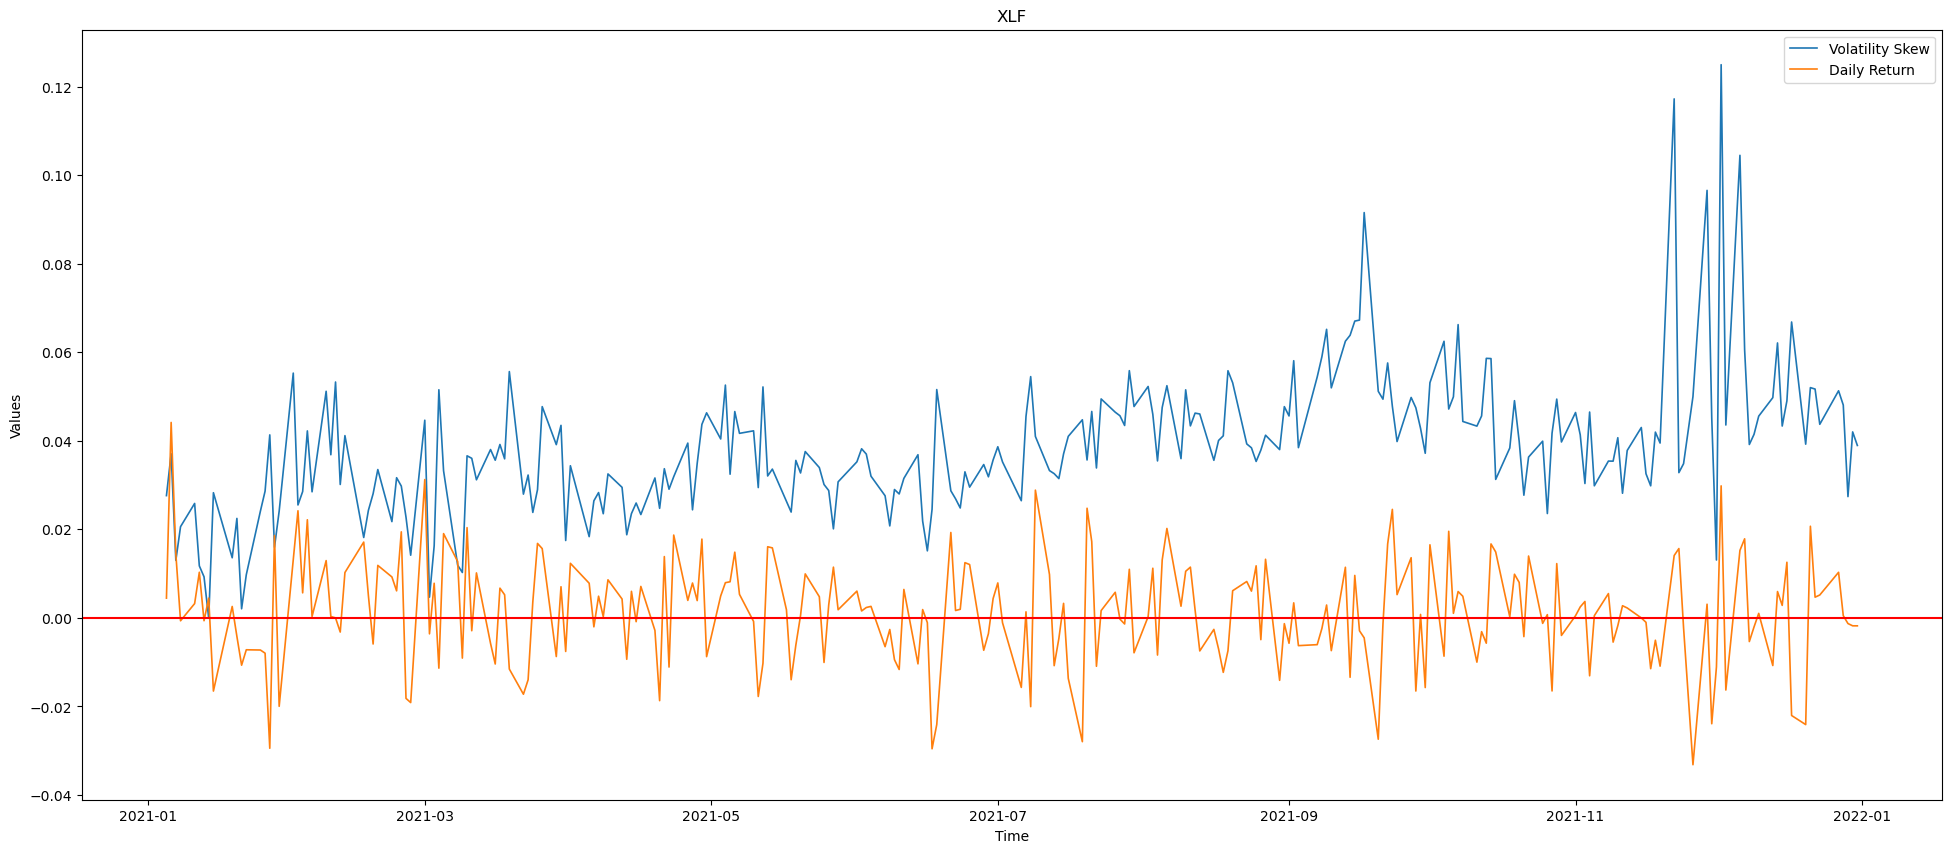

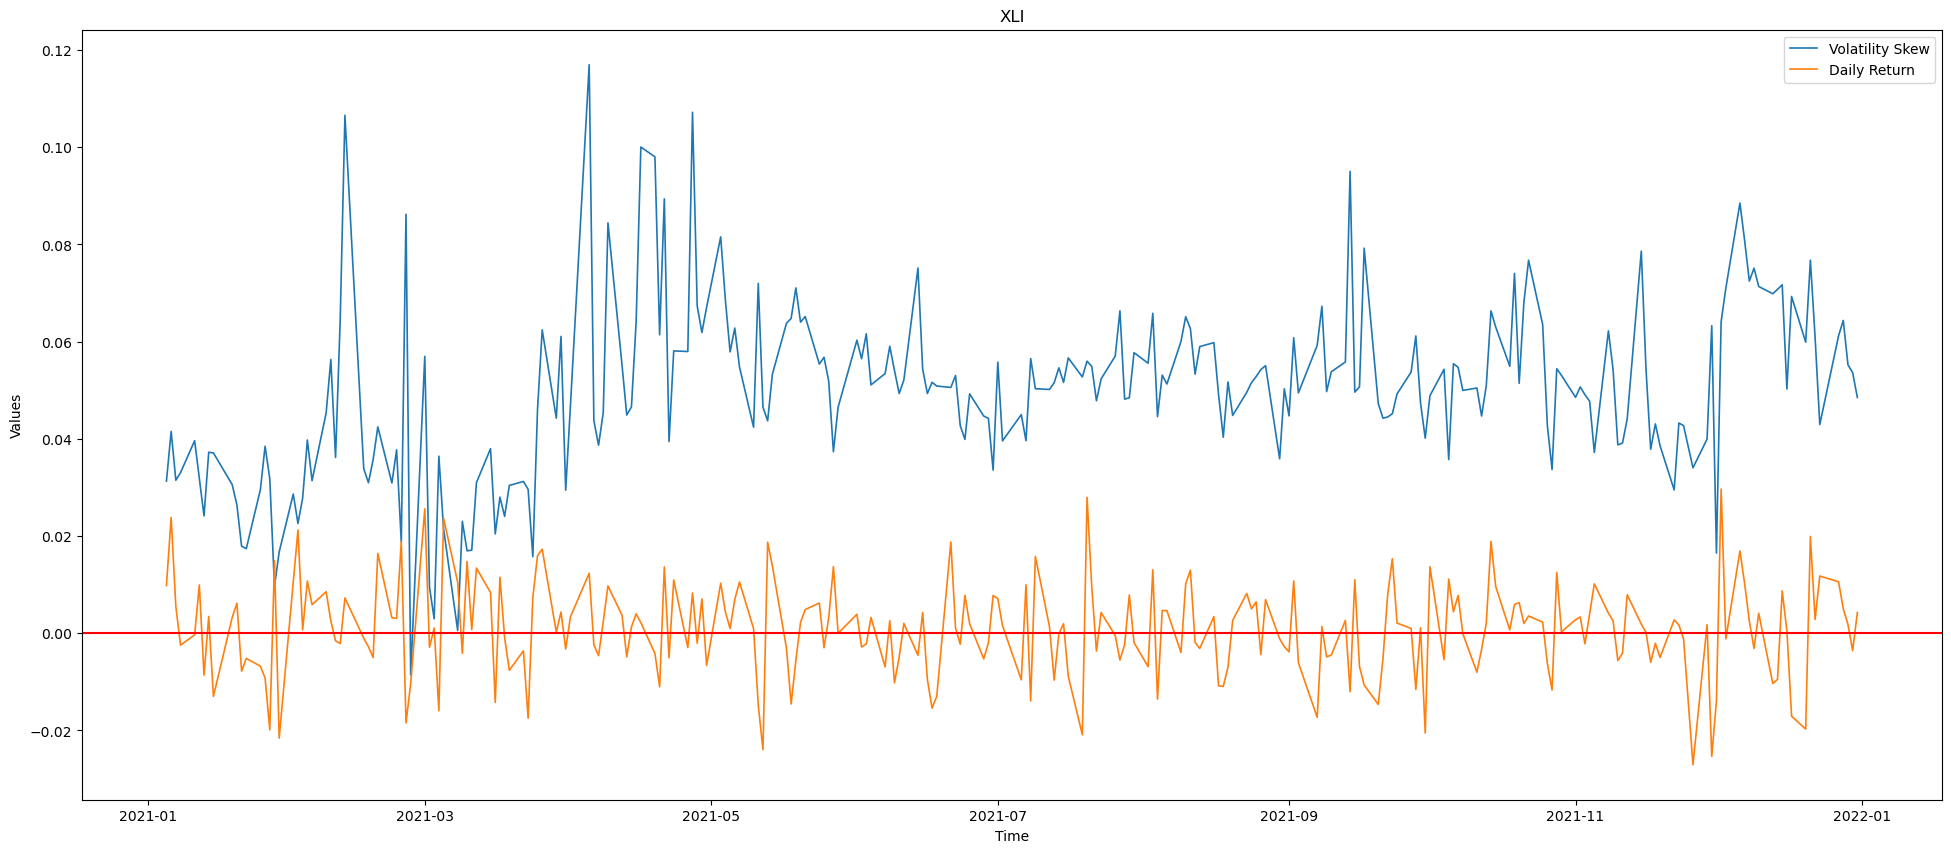

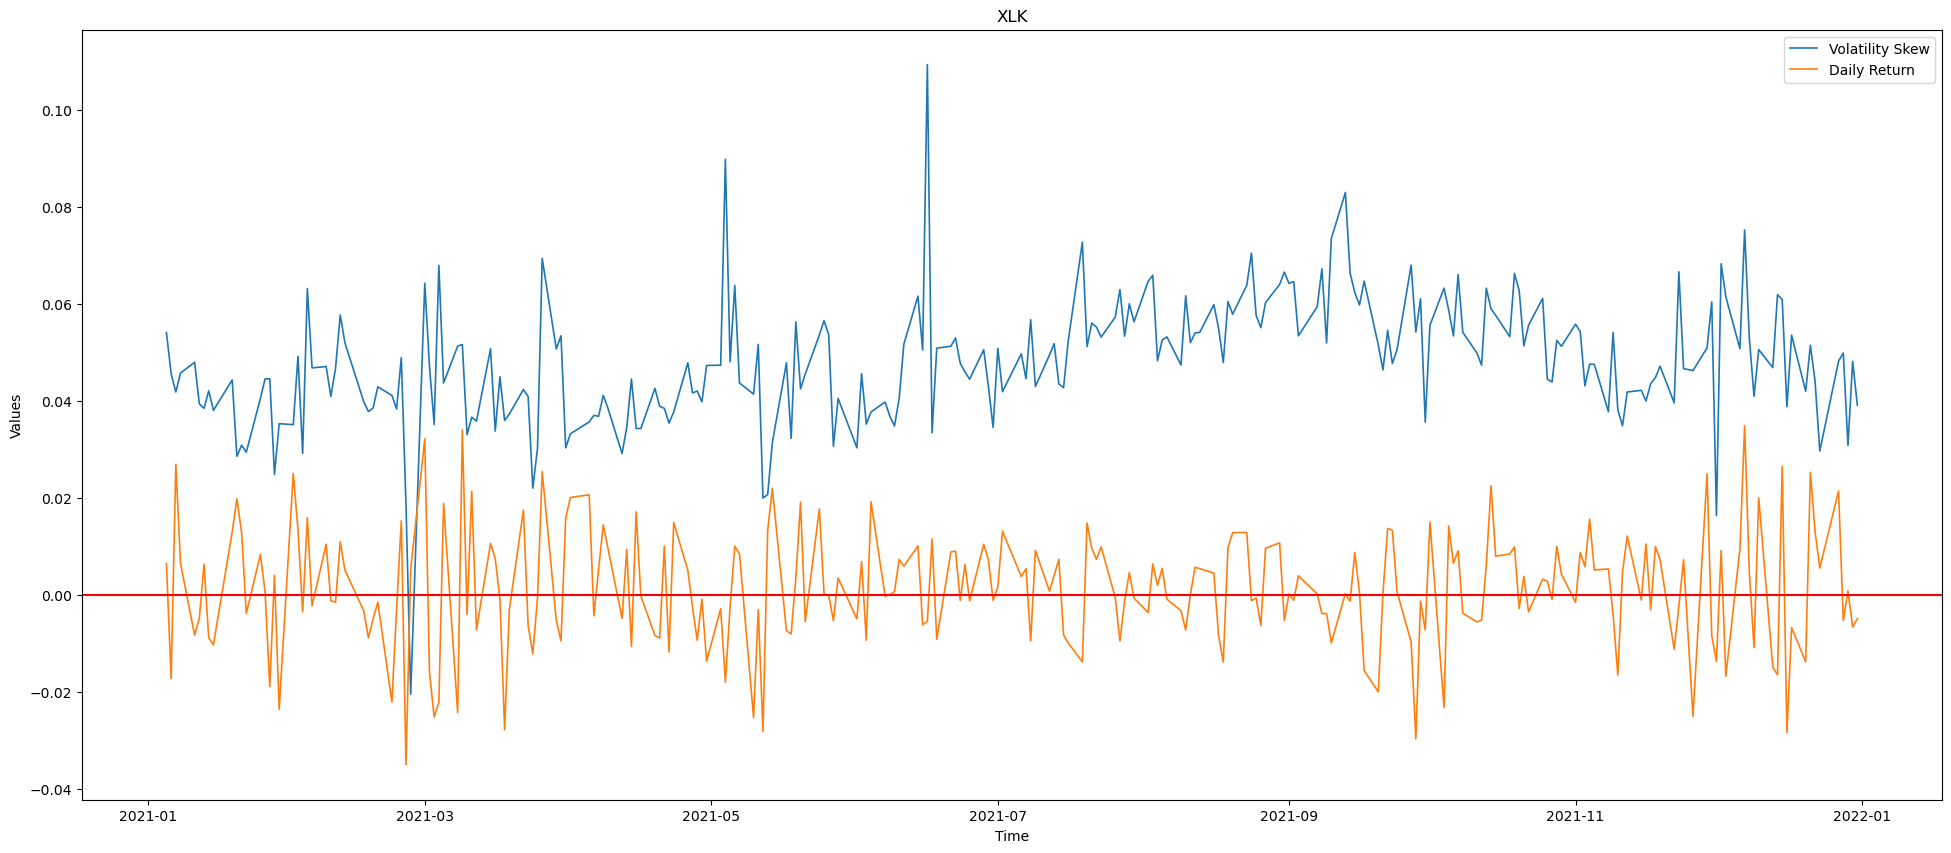

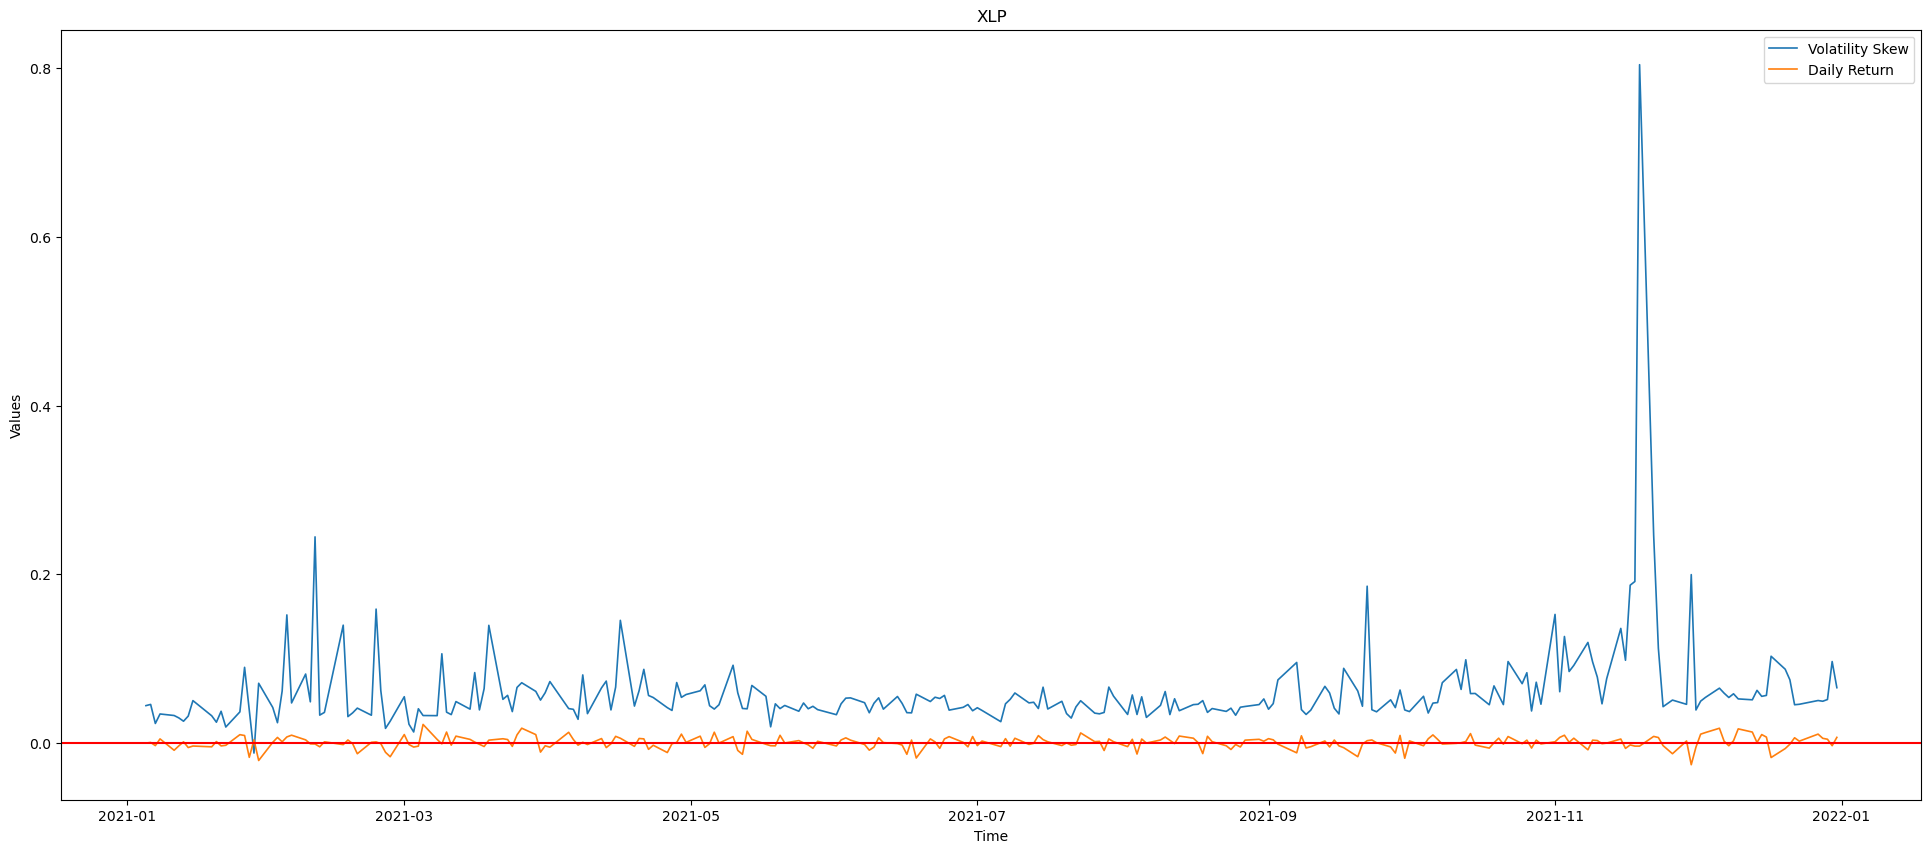

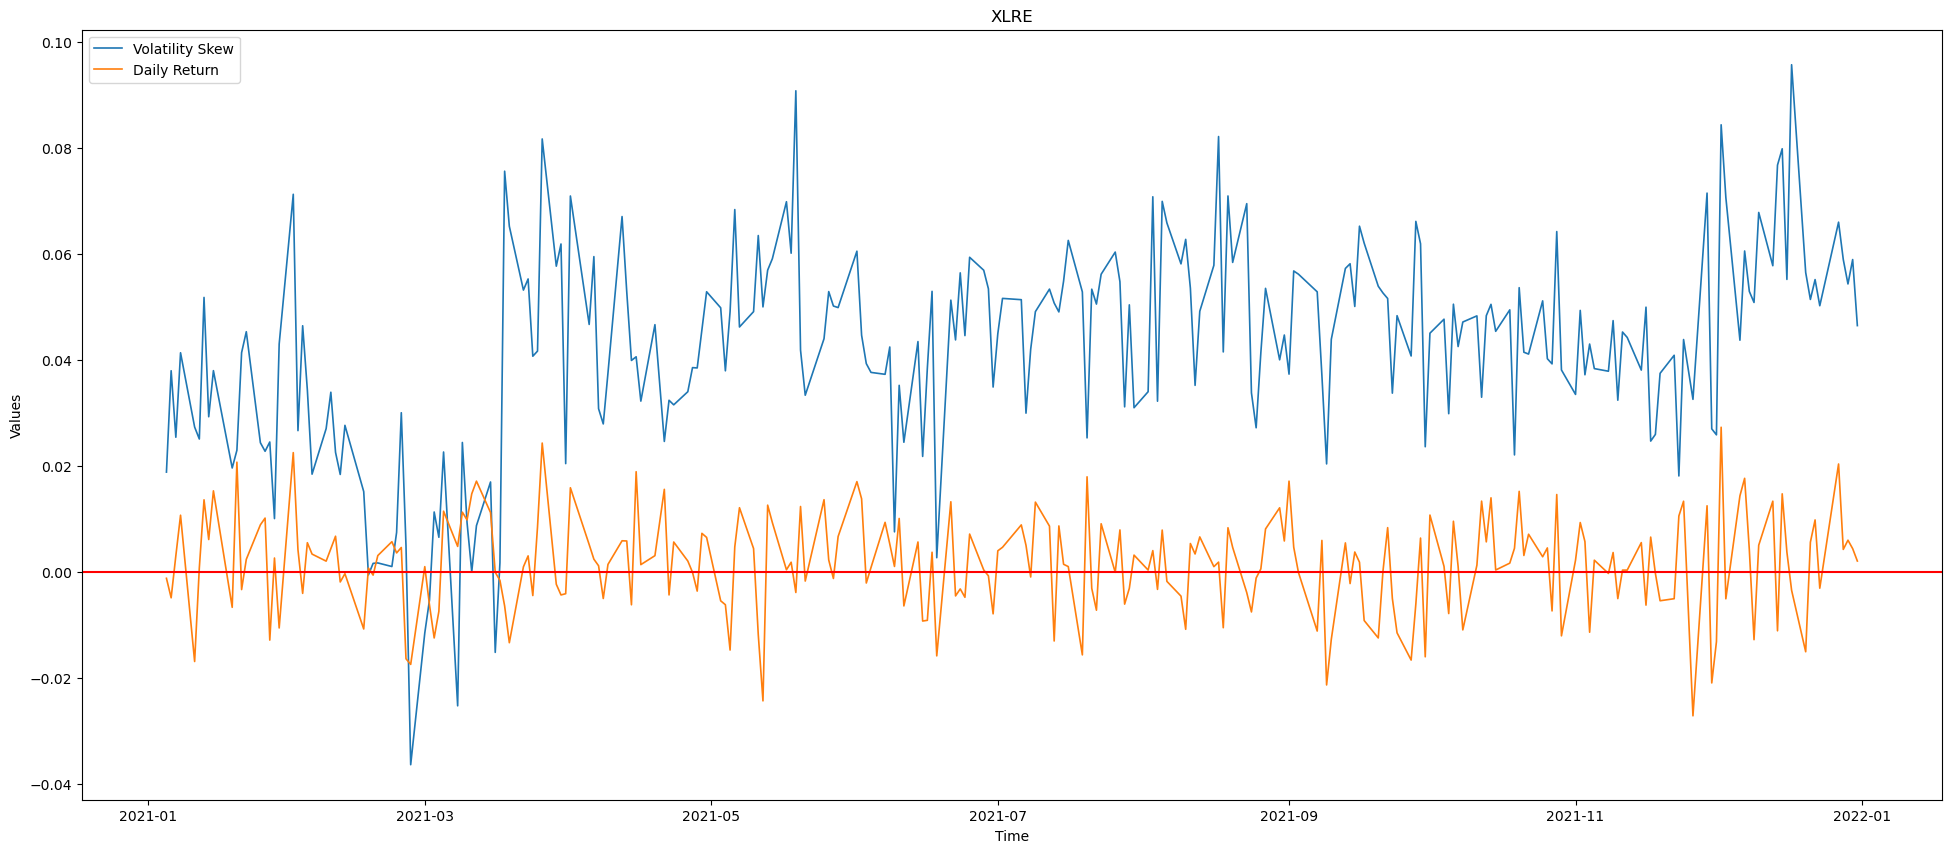

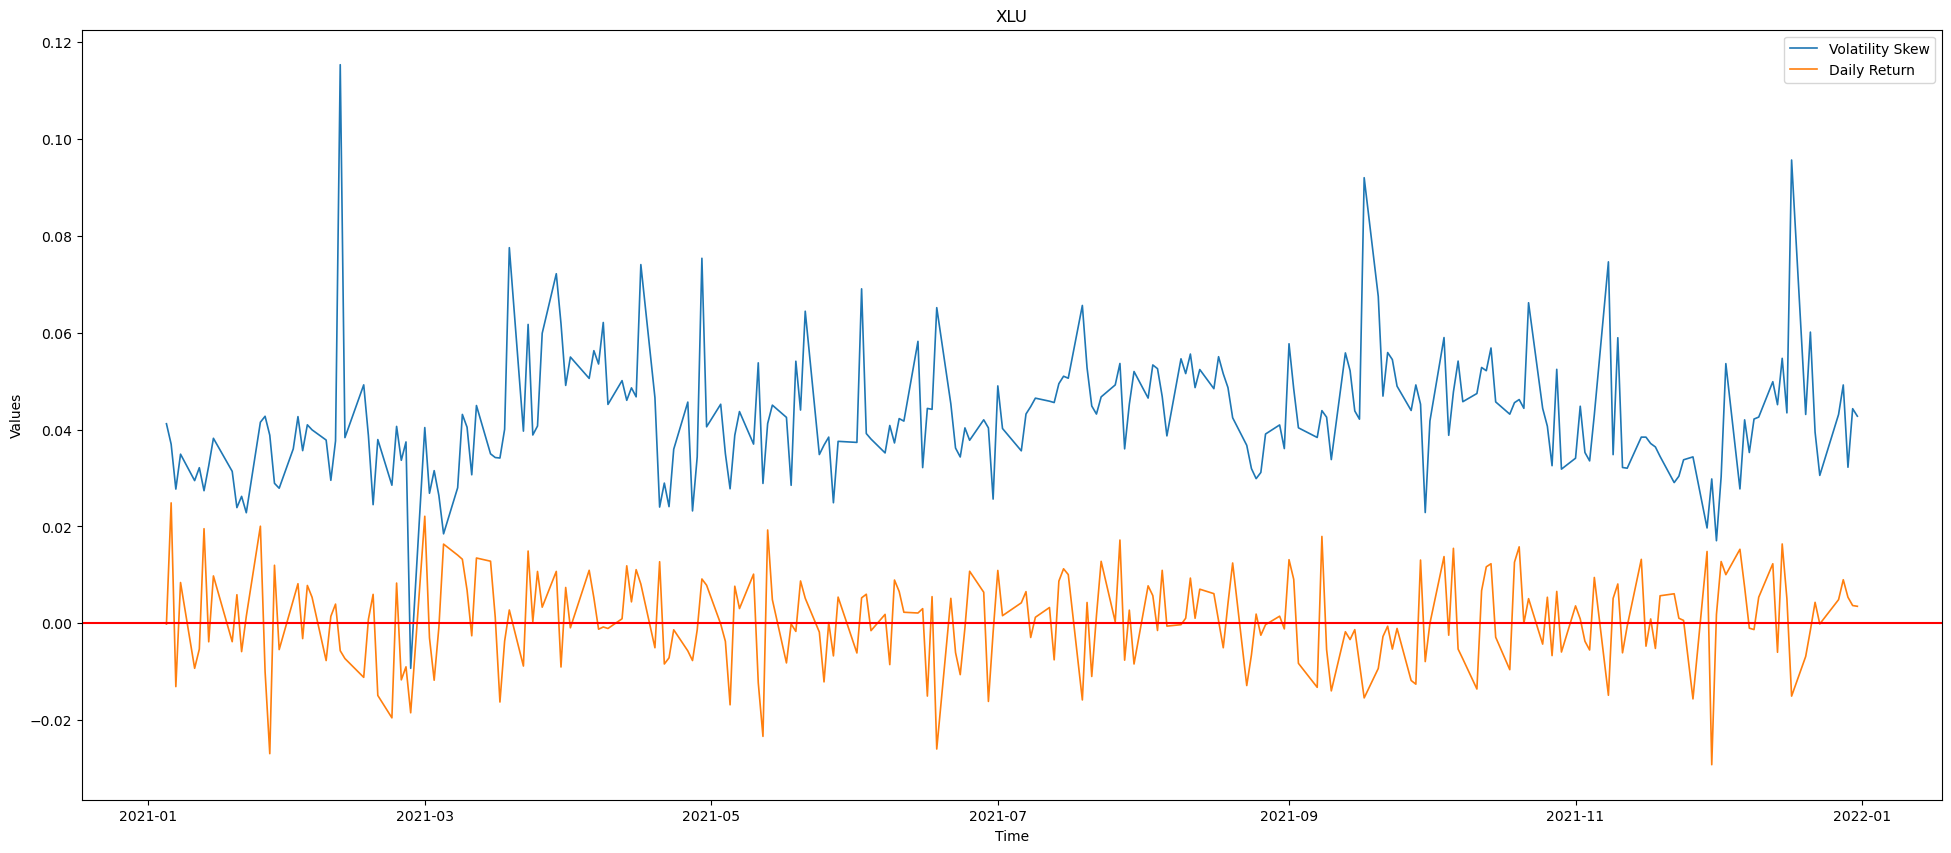

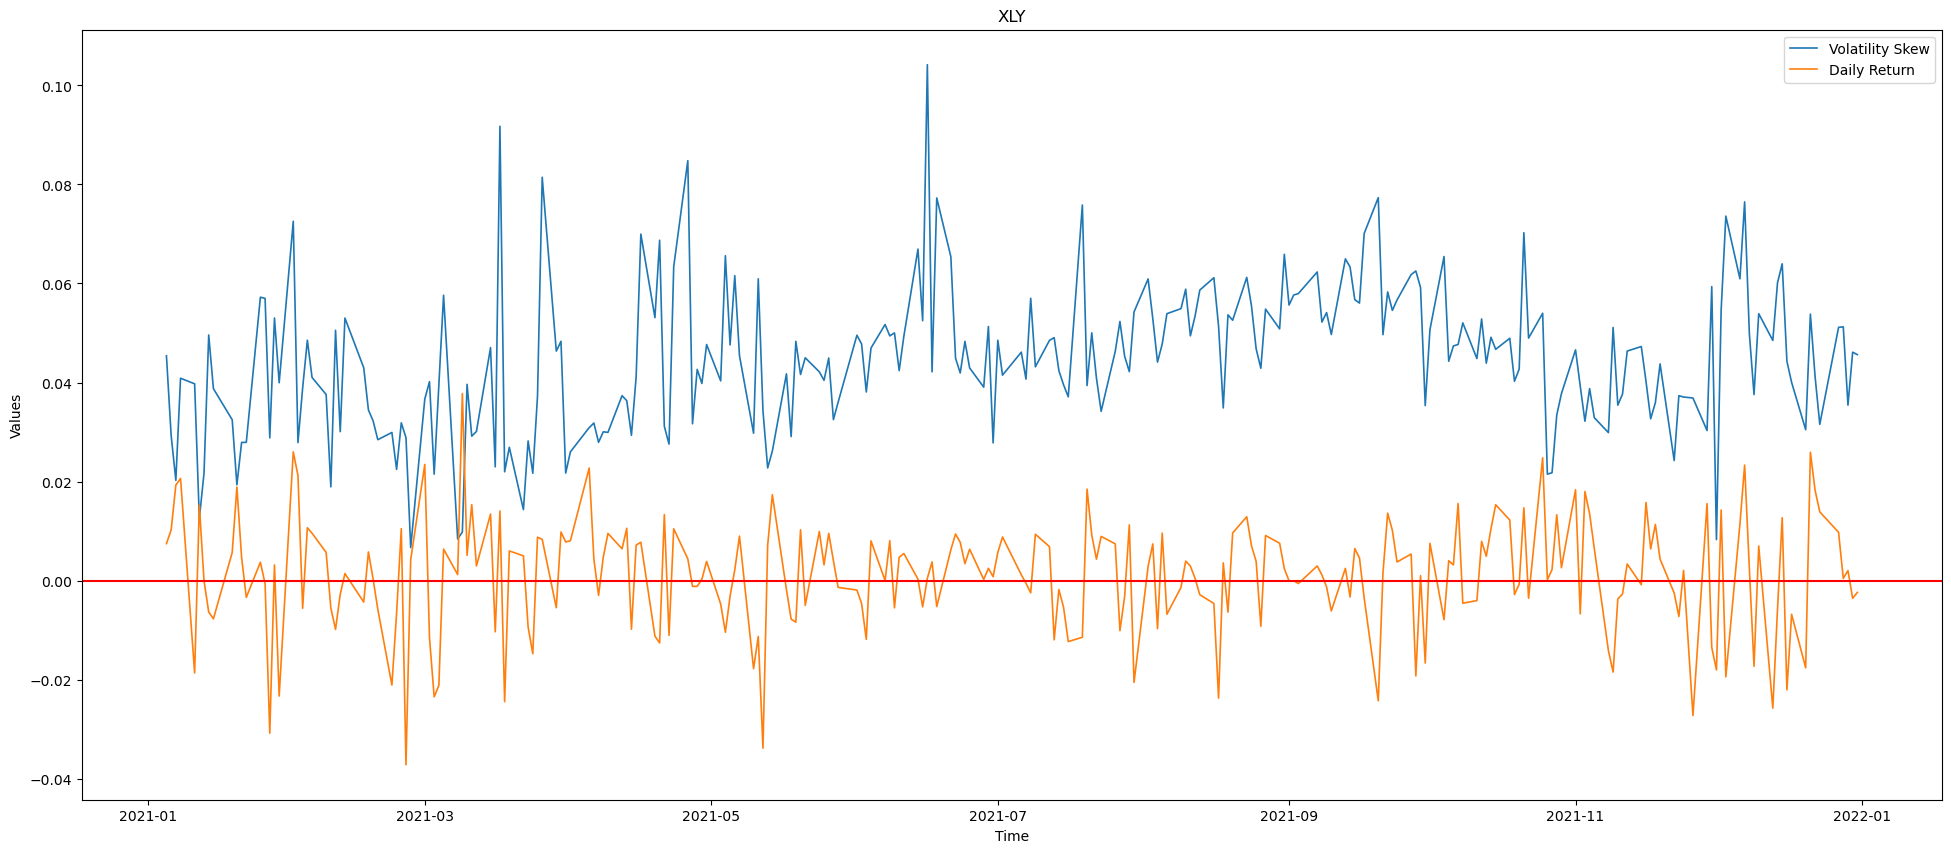

In [47]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

ticker_list = merged['ticker'].unique()

for ticker in ticker_list:
    sub_df = merged[merged['ticker'] == ticker]
    sub_df.set_index('date', inplace = True)
    plt.figure(figsize=(24, 10))
    skew = sub_df['skew'].values
    ret = sub_df['ret'].values
    
    plt.plot(sub_df.index, skew, label='Volatility Skew', linewidth=1.2)
    plt.plot(sub_df.index, ret, label='Daily Return', linewidth=1.2)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title(f'{ticker}')
    plt.show()